In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [2]:
mat = loadmat('ex3data1.mat')

In [3]:
X = mat['X']
y = mat['y']

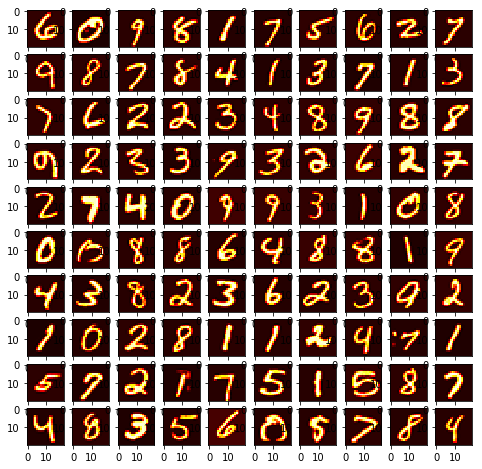

In [4]:
# Visualize the data
import matplotlib.image as mpimg
fig, axis = plt.subplots(10,10,figsize=(8,8))

for i in range(10):
    for j in range(10):
        axis[i,j].imshow(X[np.random.randint(0,5001),:].reshape(20,20, order='F'), cmap='hot')

In [5]:
# Sigmoid function
def sigmoid(z):
    
    return 1/(1+np.exp(-z))

In [6]:
# Linear Logistic Regression
def lrCostFunction(X, y, theta, lamda):
    
    m, n = X.shape
    
    X = np.hstack((np.ones((m,1)),X))
    
    # Compute Cost function with regulerization
    predictions = sigmoid(X@theta)
    error = (-y*np.log(predictions))-((1-y)*np.log(1-predictions))
    cost = 1/m * sum(error)
    regCost = cost + (lamda/(2*m)) * sum(theta[1:]**2)
    
    j_0 = 1/m * (X.T @ (predictions-y))[0]
    j_1 = 1/m * (X.T @ (predictions-y))[1:] + (lamda/m) * theta[1:]
    grad = np.vstack((j_0[:, np.newaxis], j_1))
    
    return regCost[0], grad

In [7]:
n = X.shape[1]
theta = np.zeros((n+1,1))
regCost, grad = lrCostFunction(X, y, theta, lamda=3)
print('RegCost: ',regCost,', grad size: ', grad.shape)

RegCost:  -17.05142064177608 , grad size:  (401, 1)


In [8]:
# Compute Gradient Descent with Regularization
def gradientDescent(X, y, theta, alpha, lamda, number_iterations):
    
    m, n = X.shape
    j_history = []
    
    # Compute Gradient Descent
    for i in range(number_iterations):
        
        cost, grad = lrCostFunction(X, y, theta, lamda)
        theta = theta - (alpha*grad)
        j_history.append(cost)
    
    return theta, j_history        

In [9]:
def oneVsAll(X, y, theta, number_labels):
    
    j_all = []
    theta_all = []
    
    for i in range(1, number_labels+1):
        
        theta, j_hist = gradientDescent(X, np.where(y==i, 1, 0), theta, 1, 0.1, 300)
        j_all.extend(j_hist)
        theta_all.extend(theta)
    
    return np.array(theta_all).reshape(number_labels, n+1), j_all

In [10]:
n = X.shape[1]
theta = np.zeros((n+1, 1))
theta_all, j_all = oneVsAll(X, y, theta, 10)
print('Size of Theta: ',theta_all.shape,', Size of Cos: ',len(j_all))

Size of Theta:  (10, 401) , Size of Cos:  3000


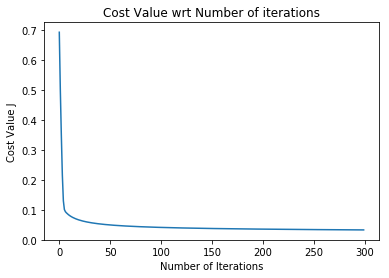

In [11]:
# PLotting Cost Function
plt.plot(j_all[0:300])
plt.xlabel('Number of Iterations')
plt.ylabel('Cost Value J')
plt.title('Cost Value wrt Number of iterations')
plt.show()

In [12]:
# Predictions oneVsAll
def predictOneVsAll(X, theta):
    
    m = len(X)
    X = np.hstack((np.ones((m,1)), X))
    
    pred = X @ theta.T
    
    return np.argmax(pred, axis=1)+1

In [13]:
predictions = predictOneVsAll(X, theta_all)
print("Training set Accuracy ",sum(predictions[:,np.newaxis]==y)[0]/5000*100,'%')

Training set Accuracy  91.28 %


In [14]:
mat = loadmat('ex3weights.mat')
Theta1 = mat['Theta1']
Theta2 = mat['Theta2']
print('theta1: ',Theta1.shape,', theta2: ',Theta2.shape)

theta1:  (25, 401) , theta2:  (10, 26)


In [15]:
# NN Forward propagations
def predictions(X, theta1, theta2):
    
    m, n = X.shape
    a1 = np.hstack((np.ones((m,1)),X))
    
    z2 = a1 @ theta1.T
    a2 = sigmoid(z2)    
    a2 = np.hstack((np.ones((a2.shape[0],1)),a2))
    
    z3 = a2 @ theta2.T
    a3 = sigmoid(z3)
    pred = np.argmax(a3, axis=1)+1
    
    return pred

In [16]:
pred = predictions(X, Theta1, Theta2)

print("Accuracy on training data using NN's given weights: ",sum(pred[:,np.newaxis]==y)[0]/5000*100,'%')

Accuracy on training data using NN's given weights:  97.52 %


In [17]:
def gradientSigmoid(z):
    
    return sigmoid(z) * (1-sigmoid(z))

In [35]:
# Compute Neural Network Cost Function
def nnCostFunction(params, number_input, number_hidden, number_output, X, y, lamda):
    
    theta1 = params[:((number_input+1)*number_hidden)].reshape(number_hidden, number_input+1)
    theta2 = params[((number_input+1)*number_hidden):].reshape(number_output,number_hidden+1)
    
    m, n = X.shape
    J = 0
    y10 = np.zeros((m, number_output))
    
    # Compute cost
    X = np.hstack((np.ones((m,1)),X))
    a1 = sigmoid(X@theta1.T)
    a1 = np.hstack((np.ones((a1.shape[0],1)),a1))
    a2 = sigmoid(a1@theta2.T)
    
    for i in range(1, number_output+1):
        y10[:,i-1][:,np.newaxis] = np.where(y==i, 1,0)
    for j in range(number_output):
        J = J + sum((-y10[:,j]*np.log(a2[:,j]))-(1-y10[:,j])*np.log(1-a2[:,j]))
    
    cost = 1/m * J
    reg_cost = cost + lamda/(2*m) * ((np.sum(theta1[:,1:])**2) + (np.sum(theta2[:,1:])**2))
    
    # Implement Backpropagation to compute gradient
    grad1 = np.zeros((theta1.shape))
    grad2 = np.zeros((theta2.shape))
    
    for i in range(m):
        Xi = X[i,:] # 1X401
        a1i = a1[i,:] # 
        a2i = a2[i,:]
        
        d2 = a2i - y10[i,:]
        d1 = (theta2.T @ d2.T) * gradientSigmoid(np.hstack((1, Xi @ theta1.T)))
        grad1 = grad1 + d1[1:][:,np.newaxis] @ Xi[:,np.newaxis].T
        grad2 = grad2 + d2.T[:,np.newaxis] @ a1i[:,np.newaxis].T
    
    grad1 = 1/m*grad1
    grad2 = 1/m*grad2
    
    grad1_reg = grad1 + (lamda/m) * np.hstack((np.zeros((theta1.shape[0],1)),theta1[:,1:]))
    grad2_reg = grad2 + (lamda/m) * np.hstack((np.zeros((theta2.shape[0],1)),theta2[:,1:]))
    
    return cost, grad1, grad2, grad1_reg, grad2_reg, reg_cost
    

In [36]:
params = np.append(Theta1.flatten(), Theta2.flatten())
number_input = 400
number_hidden = 25
number_output = 10
cost, grad1, grad2, reg_grad1, reg_grad2, reg_cost = nnCostFunction(params, number_input, number_hidden, number_output, X, y, 1)

In [37]:
print('Cost: ',cost,', Regu Cost: ',reg_cost)

Cost:  0.2876291651613188 , Regu Cost:  1.1779790480260264


In [38]:
# Weights, Random Initialization 
def randomInitializationWeights(L_in, L_out):
    
    epi = (6**1/2)/((L_in-L_out)**1/2)
    
    weights = np.random.rand(L_out, L_in+1) * (2*epi) - epi
    
    return weights

In [49]:
# compute NN Gradient Descent
def nnGradientDescent(params, number_input, number_hidden, number_output, X, y, lamda, alpha, number_iterations):
    
    theta1 = params[:((number_input+1)*number_hidden)].reshape(number_hidden, number_input+1)
    theta2 = params[((number_input+1)*number_hidden):].reshape(number_output,number_hidden+1)
    
    m, n = X.shape
    j_history = []
    
    for i in range(number_iterations):
        nn_params = np.append(theta1.flatten(),theta2.flatten())
        cost, grad1, grad2, reg_grad1, reg_grad2, reg_cost = nnCostFunction(nn_params, number_input, number_hidden, number_output, X, y, lamda)
        theta1 = theta1 - (alpha*grad1)
        theta2 = theta2 - (alpha*grad2)
        j_history.append(cost)
    
    nn_params = np.append(theta1.flatten(),theta2.flatten())
    return nn_params, j_history
        

In [50]:
input_size = 400
hidden_size = 25
output = 10
theta1 = randomInitializationWeights(input_size, hidden_size)
theta2 = randomInitializationWeights(hidden_size, output)
params = np.append(theta1.flatten(), theta2.flatten())
nn_params, j_history = nnGradientDescent(params, input_size, hidden_size, output, X, y, 1, 0.8, 800)
Theta1 = nn_params[:((input_size+1)*hidden_size)].reshape(hidden_size, input_size+1)
Theta2 = nn_params[((input_size+1)*hidden_size):].reshape(output,hidden_size+1)

In [51]:
len(j_history)

800

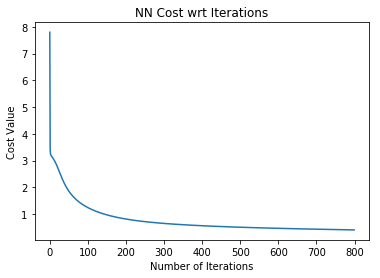

In [52]:
# Plotting NN Cost Function
plt.plot(j_history)
plt.xlabel('Number of Iterations')
plt.ylabel('Cost Value')
plt.title('NN Cost wrt Iterations')
plt.show()

In [53]:
pred = predictions(X, Theta1, Theta2)
print("Accuracy on training data using NN's given weights: ",sum(pred[:,np.newaxis]==y)[0]/5000*100,'%')

Accuracy on training data using NN's given weights:  94.64 %
